<a href="https://colab.research.google.com/github/gnitnaw/LDL/blob/main/pt_framework/c9e1_rnn_book_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how to use a recurrent neural network to solve a time series prediction problem. The goal is to predict future sales data based on historical values. More context for this code example can be found in the section "Programming Example: Forecasting Book Sales" in Chapter 9 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).


We start with initialization code. First, we import modules that we need for the network. We also load the data file into an array. We then split the data into training data (the first 80% of the data points) and test data (the remaining 20% of the months). The data is assumed to be in the file ../data/book_store_sales.csv.

# Google drive

In [2]:
!wget https://github.com/gnitnaw/LDL/raw/main/pt_framework/utilities.py
from google.colab import drive
drive.mount('/content/drive')
path_head = '/content/drive/MyDrive/Colab Notebooks/' # You have to change this. 

--2022-12-30 14:37:14--  https://github.com/gnitnaw/LDL/raw/main/pt_framework/utilities.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gnitnaw/LDL/main/pt_framework/utilities.py [following]
--2022-12-30 14:37:14--  https://raw.githubusercontent.com/gnitnaw/LDL/main/pt_framework/utilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4326 (4.2K) [text/plain]
Saving to: ‘utilities.py’

utilities.py        100%[===================>]   4.22K  --.-KB/s    in 0s      

2022-12-30 14:37:14 (35.8 MB/s) - ‘utilities.py’ saved [4326/4326]

Drive already mounted at /content/drive; to attempt to fo

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
#FILE_NAME = '../data/book_store_sales.csv'
FILE_NAME = path_head+'data/SeriesReport-ch9.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append(float(values[1]))
    file.close()
    return np.array(data, dtype=np.float32)

# Read data and split up into train and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]


The next code snippet plots the historical sales data. The data shows a clear seasonal pattern along with an indication that the overall trend in sales has changed over time, presumably due to increased online sales. For the experiment described in the book, the data started in 1992 and ended in March 2020 and showed a drop the last month. This drop was likely caused by the COVID-19 pandemic hitting the United States.


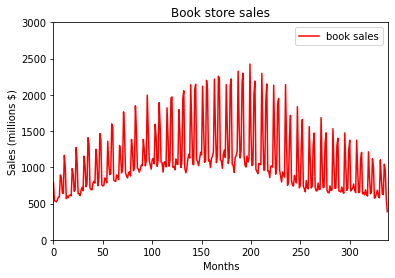

In [4]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()


For comparison purposes, create output corresponding to a naive model that predicts that the sales next month will be the same as the sales this month. Compare this to the correct data by plotting the values side by side.


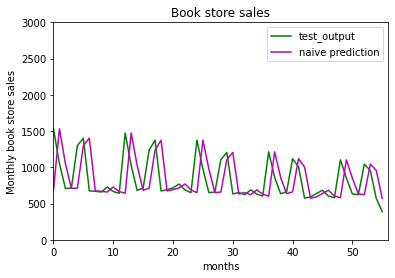

In [5]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()


The next step is to standardize the data points by subtracting the mean and dividing by the standard deviation of the training examples.


In [6]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev


In our previous examples, the datasets were already organized into individual examples. For example, we had an array of images serving as input values and an associated array of classes serving as expected output values. However, the data that we created in this example is raw historical data and not yet organized as a set of training and test examples (see figures 9-8 and 9-9 and the surrounding text in the book for more details of how we need it organized). This is the next step in our code example. The code snippet below allocates NumPy arrays for the training data and initializes all entries to 0. It then loops through the historical data and creates training examples, then does the same thing with the test data.

Finally we convert the data into PyTorch tensors and create Dataset objects.


In [7]:
# Create train examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
    train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y = np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
    test_y[i, 0] = test_sales_std[i+MIN]

# Create Dataset objects.
trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))


We are finally ready to define and train our network. This is shown in the code snippet below.

The code snippet introduces a new type of construct. At the very top we create a custom layer by defining a class LastTimestep that extends the nn.Module class. Although we did not explicitly mention it, the layers that we have used in other examples (e.g., Linear, Conv2d, Flatten, and ReLU) were all subclasses of the nn.Module class. The only thing we need to do to create a custom layer based on nn.Module is to provide our own forward() method. This method will be called with the layer inputs as parameter when the layer is invoked. The method is expected to return the resulting output.

In order to explain why we need to implement this custom layer, we first need to describe some details of the nn.RNN class used to implement recurrent networks in PyTorch. The nn.RNN class is not simply a single recurrent layer, but it implements a stack of recurrent layers, where the number of layers is determined by the first parameter to the constructor. When an instance of nn.RNN is called, it returns a tuple with two elements. The first element in the tuple is a tensor that contains the output value of the top layer for each timestep. The second element in the tuple is a tensor that contains the final output value for each of the layers. Note that since the nn.RNN module will receive a full mini-batch as input, one of the dimensions for these tensors is used to specify which training/test example in a mini-batch to access. If the batch_first argument to the constructor is set to True, then index 0 in the tensor corresponds to the mini-batch index. 

In our case, we want a single recurrent layer, and we want the final output value of this single layer to be fed to a fully connected (Linear) layer. This is why we build the custom layer. Its only task is to retrieve the right data value and drop the others on the floor. This is done by first selecting the second element in the tuple (index 1), which results in a tensor containing the final output value for each layer. From this tensor we now retrieve the value corresponding to the top layer (index 0 since our RNN will only have a single recurrent layer).

We can now create our full model by starting with an nn.RNN with a single layer and 128 units. The nn.RNN class does include the ability to select what activation function to use and we specify ReLU. The RNN module is followed by our custom layer that then feeds into a Linear layer with 128 inputs and a single output. The number of inputs (128) must match the number of outputs from the preceding layer.

As usual, we then select an optimizer and a loss function, before calling our training function to train the model.


In [8]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
    def forward(self, inputs):
        return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(1, 128, nonlinearity='relu', batch_first=True),
    LastTimestep(),
    nn.Linear(128, 1)
)

# Loss function and optimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model.
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset,
            optimizer, loss_function, 'mae')


Epoch 1/100 loss: 0.9246 - mae: 0.7140 - val_loss: 0.8124 - val_mae: 0.7161
Epoch 2/100 loss: 0.8167 - mae: 0.6345 - val_loss: 0.4235 - val_mae: 0.5319
Epoch 3/100 loss: 0.7249 - mae: 0.5805 - val_loss: 0.6145 - val_mae: 0.6278
Epoch 4/100 loss: 0.6970 - mae: 0.5576 - val_loss: 0.3665 - val_mae: 0.4794
Epoch 5/100 loss: 0.7356 - mae: 0.5601 - val_loss: 0.3836 - val_mae: 0.5071
Epoch 6/100 loss: 0.5893 - mae: 0.5616 - val_loss: 0.2992 - val_mae: 0.3622
Epoch 7/100 loss: 0.5419 - mae: 0.5326 - val_loss: 0.3016 - val_mae: 0.4210
Epoch 8/100 loss: 0.4843 - mae: 0.4974 - val_loss: 0.2508 - val_mae: 0.3051
Epoch 9/100 loss: 0.4424 - mae: 0.4706 - val_loss: 0.1966 - val_mae: 0.2910
Epoch 10/100 loss: 0.4176 - mae: 0.4680 - val_loss: 0.2378 - val_mae: 0.3287
Epoch 11/100 loss: 0.3810 - mae: 0.4432 - val_loss: 0.1877 - val_mae: 0.2918
Epoch 12/100 loss: 0.3656 - mae: 0.4197 - val_loss: 0.2489 - val_mae: 0.3214
Epoch 13/100 loss: 0.2871 - mae: 0.3954 - val_loss: 0.2002 - val_mae: 0.2772
Epoch 14

[0.12212148264927022, 0.11080042272806168]

The train_model() function will report the loss (mean squared error) and the resulting mean absolute error (since it is a regression problem). In order to get an idea of if these values are good or bad, we can compare to the corresponding metrics for the naive model described further up (that predicted that tomorrow's value is the same as today's). However, because our model works on standardized data, we need to compute the MSE and MAE for the naive model on standardized data as well. This is done in the code snippet below.


In [9]:
# Create naive prediction based on standardized data.
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)


naive test mse:  0.6334499
naive test mean abs:  0.56117445


To shed some light on how this affects the end behavior, let us use our newly trained model to do some predictions and then plot these predictions next to the actual values. The code snippet below demonstrates how this can be done.

We start with our test data which exists as a NumPy array in the variable test_X. We convert it to a PyTorch tensor with a call to torch.from_numpy(). We then move it to the GPU and use it as input to our model. This produces an output tensor with a single value for each test example. We move this tensor back to the CPU, and then call detach() and numpy() to convert it back to NumPy format. The call to detach() will create a tensor for which gradients can no longer be automatically computed. It is a necessary step before converting the tensor into NumPy format.

We then reshape the data into a 2D array. The network works with standardized data, so the output will not represent sales directly. We must first destandardize the data by doing the reverse operation compared to the standardization. That is, we multiply by the standard deviation and add the mean. We then plot the data.


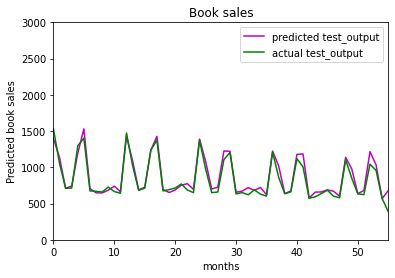

In [10]:
# Use trained model to predict the test data
inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output.
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-',
         label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()


For some more discussion about how the observed numerical values relate to each other and a comparison between an RNN based model and a feed-forward model, see the "Programming Example: Forecasting Book Sales" section in Chapter 9, which describes the results observed for an equivalent implementation in TensorFlow.
